<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#A-simple-neural-network-in-Numpy" data-toc-modified-id="A-simple-neural-network-in-Numpy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A simple neural network in Numpy</a></span><ul class="toc-item"><li><span><a href="#Define-backpropagation-in-numpy" data-toc-modified-id="Define-backpropagation-in-numpy-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define backpropagation in numpy</a></span></li><li><span><a href="#Train-the-network" data-toc-modified-id="Train-the-network-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train the network</a></span></li></ul></li><li><span><a href="#Getting-the-data" data-toc-modified-id="Getting-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the data</a></span></li><li><span><a href="#Simple-postprocessing" data-toc-modified-id="Simple-postprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple postprocessing</a></span><ul class="toc-item"><li><span><a href="#Add-station-information-with-embeddings" data-toc-modified-id="Add-station-information-with-embeddings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Add station information with embeddings</a></span></li><li><span><a href="#What-about-a-neural-network?" data-toc-modified-id="What-about-a-neural-network?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>What about a neural network?</a></span></li></ul></li><li><span><a href="#Adding-more-variables" data-toc-modified-id="Adding-more-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Adding more variables</a></span><ul class="toc-item"><li><span><a href="#Simple-linear-net-with-auxiliary-variables" data-toc-modified-id="Simple-linear-net-with-auxiliary-variables-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simple linear net with auxiliary variables</a></span></li><li><span><a href="#Auxiliary-variables-with-station-embeddings" data-toc-modified-id="Auxiliary-variables-with-station-embeddings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Auxiliary variables with station embeddings</a></span></li><li><span><a href="#Neural-network" data-toc-modified-id="Neural-network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Neural network</a></span></li><li><span><a href="#A-more-complex-neural-network" data-toc-modified-id="A-more-complex-neural-network-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>A more complex neural network</a></span></li><li><span><a href="#Hmmm,-weird..." data-toc-modified-id="Hmmm,-weird...-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Hmmm, weird...</a></span></li></ul></li><li><span><a href="#A-longer-training-period" data-toc-modified-id="A-longer-training-period-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A longer training period</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Neural networks for post-processing NWP forecasts

In [182]:
# Imports 
import numpy as np
import sys
sys.path.append('../')   # This is where all the python files are!
from importlib import reload
import utils; reload(utils)
from utils import *
import keras_models; reload(keras_models)
from keras_models import *
from losses import crps_cost_function
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
import seaborn as sns
sns.set_style('dark')
sns.set_context('poster')
from tqdm import tqdm
from collections import OrderedDict
from IPython.display import HTML

Anaconda environment: cbrain_gpu
Linux 4.4.0-101-generic


In [2]:
# Basic setup
# DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU

## A simple neural network in Numpy

So what is a neural network anyway. Let's start by looking at a picture.

![Neural network](general_nn.png)

A neural network consists of several layers of interconnected nodes. Each node represents a weighted sum of all the nodes in the previous layers plus a bias.

$$\sum_j w_j x_j + b$$

Additionally, each hidden layer is modified by a non-linear function $g(z)$. One very simple and popular activation function is called ReLU:

$$\mathrm{relu}(z) = \mathrm{max}(0, z)$$

Let's build a simplified network with one input and one output in pure Numpy.

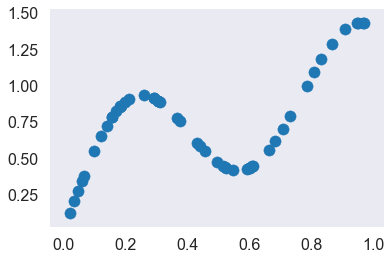

In [138]:
# Create the data
n_samples = 50
x = np.expand_dims(np.random.uniform(0, 1, n_samples), -1)
y = np.sin(2 * x) + 0.5 * np.sin(8 * x)
plt.scatter(x, y);

In [158]:
# Initialize the weights and biases for the input --> hidden layer step
n_hidden = 100   # Number of nodes in hidden layer
w1 = np.random.normal(size=(1, n_hidden))   # a matrix
b1 = np.random.normal(size=n_hidden)        # a vector

In [159]:
# Do the first step 
hidden = np.dot(x, w1) + b1
hidden.shape

(50, 100)

In [160]:
# Here comes the non-linearity
def relu(z):
    return np.maximum(0, z)

In [161]:
hidden = relu(hidden)

In [162]:
# Now the weights and biases for the hidden --> output step
w2 = np.random.normal(size=(n_hidden, 1))
b2 = np.random.normal(size=1)

In [164]:
# Now the second step
preds = np.dot(hidden, w2) + b2
preds.shape

(50, 1)

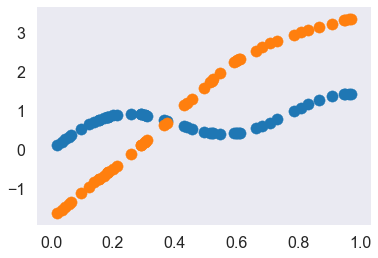

In [165]:
plt.scatter(x, y);
plt.scatter(x, preds);

Now this is of course just some random garbage. The goal of the optimization algorithm is to change the weights and biases to get the output closer to the target. Mathematically, we are minimizing a loss function, for example the mean squared error.

$$L = \frac{1}{N_\mathrm{{samples}}} \sum_{i=1}^{N_\mathrm{{samples}}} (\mathrm{output} - \mathrm{target})^2$$

To minimize this loss we are using stochastic gradient descent. For this we need to compute the gradient of the loss with respect to all weights and biases. Basically, this mean using the chain rule of calculus. The algorithm to do this efficiently is called backpropagation.

In [146]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [147]:
mse(out, y)

25.686304399190636

### Define backpropagation in numpy

In [166]:
# Some helper function to reset the weights
def init_weights(n_hidden):
    w1 = np.random.normal(size=(1, n_hidden))   # a matrix
    b1 = np.random.normal(size=n_hidden)        # a vector
    w2 = np.random.normal(size=(n_hidden, 1))
    b2 = np.random.normal(size=1)
    return [w1, w2], [b1, b2]

In [239]:
# First define the forward pass.
def forward_pass(x, weights, biases):
    hidden = relu(np.dot(x, weights[0]) + biases[0])
    return np.dot(hidden, weights[1]) + biases[1]

In [149]:
# Define the derivative of the loss function and the activation function
def dmse(predictions, targets):
    return predictions - targets
def drelu(z):
    return 1. * (z > 0)

In [250]:
def backprop_and_update(x, y, weights, biases, lr=1e-5):
    # Compute the predictions
    hidden = relu(np.dot(x, weights[0]) + biases[0])
    preds = np.dot(hidden, weights[1]) + biases[1]
    
    # Compute the loss
    loss = mse(preds, y)
    
    # Compute Ds
    delta2 = dmse(preds, y)
    dw2 = np.dot(hidden.T, delta2)
    db2 = np.sum(delta2, axis=0)
    delta1 = np.dot(delta2, weights[1].T)  * drelu(hidden)
    dw1 = np.dot(x.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update parameters
    weights[0] -= lr * dw1
    biases[0] -= lr * db1
    weights[1] -= lr * dw2
    biases[1] -= lr * db2
    
    return loss

### Train the network

In [274]:
weights, biases = init_weights(50)

In [275]:
n_steps = 10000
saved_preds = []
pbar = tqdm(total=n_steps)
for i in range(n_steps):
    loss = backprop_and_update(x, y, weights, biases, lr=1e-4)
    pbar.update(1)
    pbar.set_postfix(OrderedDict({'loss': loss}))
    if i % 200 == 0:
        saved_preds.append(forward_pass(x, weights, biases))
pbar.close()





  0%|          | 0/10000 [00:00<?, ?it/s]



  0%|          | 1/10000 [00:00<00:15, 638.60it/s, loss=117]



  0%|          | 2/10000 [00:00<00:22, 450.98it/s, loss=57.6]



  0%|          | 3/10000 [00:00<00:23, 416.60it/s, loss=29.1]



  0%|          | 4/10000 [00:00<00:24, 399.85it/s, loss=14.9]



  0%|          | 5/10000 [00:00<00:25, 385.02it/s, loss=7.73]



  0%|          | 6/10000 [00:00<00:26, 378.67it/s, loss=4.04]



  0%|          | 7/10000 [00:00<00:26, 374.47it/s, loss=2.14]



  0%|          | 8/10000 [00:00<00:26, 373.61it/s, loss=1.14]



  0%|          | 9/10000 [00:00<00:26, 372.55it/s, loss=0.627]



  0%|          | 10/10000 [00:00<00:26, 370.52it/s, loss=0.355]



  0%|          | 11/10000 [00:00<00:26, 370.00it/s, loss=0.213]



  0%|          | 12/10000 [00:00<00:27, 369.89it/s, loss=0.139]



  0%|          | 13/10000 [00:00<00:27, 365.97it/s, loss=0.0995]



  0%|          | 14/10000 [00:00<00:27, 357.13it/s, loss=0.0789]



  0%|          | 15/10000 [00

  1%|          | 101/10000 [00:00<00:28, 345.53it/s, loss=0.044] 



  1%|          | 102/10000 [00:00<00:29, 336.51it/s, loss=0.044]



  1%|          | 102/10000 [00:00<00:29, 336.51it/s, loss=0.0439]



  1%|          | 103/10000 [00:00<00:29, 336.51it/s, loss=0.0438]



  1%|          | 104/10000 [00:00<00:29, 336.51it/s, loss=0.0436]



  1%|          | 105/10000 [00:00<00:29, 336.51it/s, loss=0.0435]



  1%|          | 106/10000 [00:00<00:29, 336.51it/s, loss=0.0434]



  1%|          | 107/10000 [00:00<00:29, 336.51it/s, loss=0.0433]



  1%|          | 108/10000 [00:00<00:29, 336.51it/s, loss=0.0432]



  1%|          | 109/10000 [00:00<00:29, 336.51it/s, loss=0.0431]



  1%|          | 110/10000 [00:00<00:29, 336.51it/s, loss=0.0429]



  1%|          | 111/10000 [00:00<00:29, 336.51it/s, loss=0.0428]



  1%|          | 112/10000 [00:00<00:29, 336.51it/s, loss=0.0427]



  1%|          | 113/10000 [00:00<00:29, 336.51it/s, loss=0.0426]



  1%|          | 114/10000 [00:00<0

  2%|▏         | 198/10000 [00:00<00:30, 320.12it/s, loss=0.0354]



  2%|▏         | 199/10000 [00:00<00:30, 320.12it/s, loss=0.0353]



  2%|▏         | 200/10000 [00:00<00:30, 320.12it/s, loss=0.0352]



  2%|▏         | 201/10000 [00:00<00:30, 320.12it/s, loss=0.0352]



  2%|▏         | 202/10000 [00:00<00:30, 320.12it/s, loss=0.0351]



  2%|▏         | 203/10000 [00:00<00:30, 320.12it/s, loss=0.0351]



  2%|▏         | 204/10000 [00:00<00:30, 320.12it/s, loss=0.035] 



  2%|▏         | 205/10000 [00:00<00:30, 320.12it/s, loss=0.0349]



  2%|▏         | 206/10000 [00:00<00:30, 320.12it/s, loss=0.0349]



  2%|▏         | 207/10000 [00:00<00:30, 320.12it/s, loss=0.0348]



  2%|▏         | 208/10000 [00:00<00:30, 320.12it/s, loss=0.0348]



  2%|▏         | 209/10000 [00:00<00:30, 320.12it/s, loss=0.0347]



  2%|▏         | 210/10000 [00:00<00:30, 320.12it/s, loss=0.0347]



  2%|▏         | 211/10000 [00:00<00:30, 320.12it/s, loss=0.0346]



  2%|▏         | 212/10000 [00:00<

  3%|▎         | 296/10000 [00:00<00:32, 302.32it/s, loss=0.0307]



  3%|▎         | 297/10000 [00:00<00:32, 302.32it/s, loss=0.0307]



  3%|▎         | 298/10000 [00:00<00:32, 302.32it/s, loss=0.0307]



  3%|▎         | 299/10000 [00:00<00:32, 302.32it/s, loss=0.0306]



  3%|▎         | 300/10000 [00:00<00:32, 302.32it/s, loss=0.0306]



  3%|▎         | 301/10000 [00:00<00:32, 302.32it/s, loss=0.0306]



  3%|▎         | 302/10000 [00:00<00:32, 302.32it/s, loss=0.0305]



  3%|▎         | 303/10000 [00:00<00:32, 302.32it/s, loss=0.0305]



  3%|▎         | 304/10000 [00:00<00:32, 302.32it/s, loss=0.0305]



  3%|▎         | 305/10000 [00:00<00:32, 302.32it/s, loss=0.0304]



  3%|▎         | 306/10000 [00:00<00:32, 302.32it/s, loss=0.0304]



  3%|▎         | 307/10000 [00:00<00:32, 302.32it/s, loss=0.0304]



  3%|▎         | 308/10000 [00:00<00:32, 302.32it/s, loss=0.0303]



  3%|▎         | 309/10000 [00:00<00:32, 302.32it/s, loss=0.0303]



  3%|▎         | 310/10000 [00:00<

  4%|▍         | 394/10000 [00:01<00:29, 322.67it/s, loss=0.0279]



  4%|▍         | 395/10000 [00:01<00:29, 322.67it/s, loss=0.0278]



  4%|▍         | 396/10000 [00:01<00:29, 322.67it/s, loss=0.0278]



  4%|▍         | 397/10000 [00:01<00:29, 322.67it/s, loss=0.0278]



  4%|▍         | 398/10000 [00:01<00:29, 322.67it/s, loss=0.0278]



  4%|▍         | 399/10000 [00:01<00:29, 322.67it/s, loss=0.0277]



  4%|▍         | 400/10000 [00:01<00:29, 322.67it/s, loss=0.0277]



  4%|▍         | 401/10000 [00:01<00:29, 322.67it/s, loss=0.0277]



  4%|▍         | 402/10000 [00:01<00:29, 322.67it/s, loss=0.0277]



  4%|▍         | 403/10000 [00:01<00:29, 322.67it/s, loss=0.0276]



  4%|▍         | 404/10000 [00:01<00:29, 322.67it/s, loss=0.0276]



  4%|▍         | 405/10000 [00:01<00:29, 322.67it/s, loss=0.0276]



  4%|▍         | 406/10000 [00:01<00:29, 322.67it/s, loss=0.0276]



  4%|▍         | 407/10000 [00:01<00:29, 322.67it/s, loss=0.0275]



  4%|▍         | 408/10000 [00:01<

  5%|▍         | 493/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 494/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 495/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 496/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 497/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 498/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▍         | 499/10000 [00:01<00:27, 347.41it/s, loss=0.0259]



  5%|▌         | 500/10000 [00:01<00:27, 347.41it/s, loss=0.0258]



  5%|▌         | 501/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 501/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 502/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 503/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 504/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 505/10000 [00:01<00:28, 337.75it/s, loss=0.0258]



  5%|▌         | 506/10000 [00:01<

  6%|▌         | 591/10000 [00:01<00:26, 361.85it/s, loss=0.0245]



  6%|▌         | 592/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 593/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 594/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 595/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 596/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 597/10000 [00:01<00:25, 361.85it/s, loss=0.0245]



  6%|▌         | 598/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 599/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 600/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 601/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 602/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 603/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 604/10000 [00:01<00:25, 361.85it/s, loss=0.0244]



  6%|▌         | 605/10000 [00:01<

  7%|▋         | 690/10000 [00:02<00:25, 371.42it/s, loss=0.0233]



  7%|▋         | 691/10000 [00:02<00:25, 371.42it/s, loss=0.0232]



  7%|▋         | 692/10000 [00:02<00:25, 371.42it/s, loss=0.0232]



  7%|▋         | 693/10000 [00:02<00:25, 371.42it/s, loss=0.0232]



  7%|▋         | 694/10000 [00:02<00:25, 371.42it/s, loss=0.0232]



  7%|▋         | 695/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 695/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 696/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 697/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 698/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 699/10000 [00:02<00:25, 369.15it/s, loss=0.0232]



  7%|▋         | 700/10000 [00:02<00:25, 369.15it/s, loss=0.0231]



  7%|▋         | 701/10000 [00:02<00:25, 369.15it/s, loss=0.0231]



  7%|▋         | 702/10000 [00:02<00:25, 369.15it/s, loss=0.0231]



  7%|▋         | 703/10000 [00:02<

  8%|▊         | 788/10000 [00:02<00:24, 378.36it/s, loss=0.022] 



  8%|▊         | 789/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 790/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 791/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 792/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 793/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 794/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 795/10000 [00:02<00:24, 378.36it/s, loss=0.022]



  8%|▊         | 796/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 797/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 798/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 799/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 800/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 801/10000 [00:02<00:24, 378.36it/s, loss=0.0219]



  8%|▊         | 802/10000 [00:02<00:24, 

  9%|▉         | 887/10000 [00:02<00:23, 385.85it/s, loss=0.0208]



  9%|▉         | 888/10000 [00:02<00:23, 385.85it/s, loss=0.0208]



  9%|▉         | 889/10000 [00:02<00:23, 385.85it/s, loss=0.0208]



  9%|▉         | 890/10000 [00:02<00:23, 385.85it/s, loss=0.0208]



  9%|▉         | 891/10000 [00:02<00:23, 385.85it/s, loss=0.0207]



  9%|▉         | 892/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 892/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 893/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 894/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 895/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 896/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 897/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 898/10000 [00:02<00:23, 386.99it/s, loss=0.0207]



  9%|▉         | 899/10000 [00:02<00:23, 386.99it/s, loss=0.0206]



  9%|▉         | 900/10000 [00:02<

 10%|▉         | 985/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 986/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 987/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 988/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 989/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 990/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 991/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 992/10000 [00:02<00:23, 386.91it/s, loss=0.0196]



 10%|▉         | 993/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 994/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 995/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 996/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 997/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 998/10000 [00:02<00:23, 386.91it/s, loss=0.0195]



 10%|▉         | 999/10000 [00:02<

 11%|█         | 1083/10000 [00:03<00:23, 381.86it/s, loss=0.0186]



 11%|█         | 1084/10000 [00:03<00:23, 381.86it/s, loss=0.0186]



 11%|█         | 1085/10000 [00:03<00:23, 381.86it/s, loss=0.0185]



 11%|█         | 1086/10000 [00:03<00:23, 381.86it/s, loss=0.0185]



 11%|█         | 1087/10000 [00:03<00:23, 381.86it/s, loss=0.0185]



 11%|█         | 1088/10000 [00:03<00:23, 381.86it/s, loss=0.0185]



 11%|█         | 1089/10000 [00:03<00:23, 381.86it/s, loss=0.0185]



 11%|█         | 1090/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1090/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1091/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1092/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1093/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1094/10000 [00:03<00:23, 384.58it/s, loss=0.0185]



 11%|█         | 1095/10000 [00:03<00:23, 384.58it/s, loss=0.0184]



 11%|█         | 109

 12%|█▏        | 1180/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1181/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1182/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1183/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1184/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1185/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1186/10000 [00:03<00:23, 381.48it/s, loss=0.0176]



 12%|█▏        | 1187/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1188/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1189/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1190/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1191/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1192/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 1193/10000 [00:03<00:23, 381.48it/s, loss=0.0175]



 12%|█▏        | 119

 13%|█▎        | 1278/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1279/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1280/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1281/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1282/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1283/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1284/10000 [00:03<00:22, 381.98it/s, loss=0.0167]



 13%|█▎        | 1285/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1285/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1286/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1287/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1288/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1289/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 1290/10000 [00:03<00:22, 382.12it/s, loss=0.0167]



 13%|█▎        | 129

 14%|█▍        | 1375/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1376/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1377/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1378/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1379/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1380/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1381/10000 [00:03<00:22, 382.99it/s, loss=0.016]



 14%|█▍        | 1382/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1383/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1384/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1385/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1386/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1387/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1388/10000 [00:03<00:22, 382.99it/s, loss=0.0159]



 14%|█▍        | 1389/10000

 15%|█▍        | 1473/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1474/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1475/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1476/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1477/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1478/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1479/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1480/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1481/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1482/10000 [00:04<00:21, 388.14it/s, loss=0.0153]



 15%|█▍        | 1483/10000 [00:04<00:21, 389.44it/s, loss=0.0153]



 15%|█▍        | 1483/10000 [00:04<00:21, 389.44it/s, loss=0.0153]



 15%|█▍        | 1484/10000 [00:04<00:21, 389.44it/s, loss=0.0152]



 15%|█▍        | 1485/10000 [00:04<00:21, 389.44it/s, loss=0.0152]



 15%|█▍        | 148

 16%|█▌        | 1570/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1571/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1572/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1573/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1574/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1575/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1576/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1577/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1578/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1579/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1580/10000 [00:04<00:21, 393.02it/s, loss=0.0147]



 16%|█▌        | 1581/10000 [00:04<00:21, 393.02it/s, loss=0.0146]



 16%|█▌        | 1582/10000 [00:04<00:21, 393.02it/s, loss=0.0146]



 16%|█▌        | 1583/10000 [00:04<00:21, 393.02it/s, loss=0.0146]



 16%|█▌        | 158

 17%|█▋        | 1667/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1668/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1669/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1670/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1671/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1672/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1673/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1674/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1675/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1676/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1677/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1678/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1679/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 1680/10000 [00:04<00:21, 386.54it/s, loss=0.0141]



 17%|█▋        | 168

 18%|█▊        | 1764/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1765/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1766/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1767/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1768/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1769/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1770/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1771/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1772/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1773/10000 [00:04<00:21, 385.84it/s, loss=0.0136]



 18%|█▊        | 1774/10000 [00:04<00:21, 385.84it/s, loss=0.0135]



 18%|█▊        | 1775/10000 [00:04<00:21, 385.84it/s, loss=0.0135]



 18%|█▊        | 1776/10000 [00:04<00:21, 385.84it/s, loss=0.0135]



 18%|█▊        | 1777/10000 [00:04<00:21, 385.84it/s, loss=0.0135]



 18%|█▊        | 177

 19%|█▊        | 1861/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1862/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1863/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1864/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1865/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1866/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1867/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1868/10000 [00:05<00:21, 384.99it/s, loss=0.0131]



 19%|█▊        | 1869/10000 [00:05<00:21, 384.99it/s, loss=0.013] 



 19%|█▊        | 1870/10000 [00:05<00:21, 384.99it/s, loss=0.013]



 19%|█▊        | 1871/10000 [00:05<00:21, 384.99it/s, loss=0.013]



 19%|█▊        | 1872/10000 [00:05<00:21, 384.99it/s, loss=0.013]



 19%|█▊        | 1873/10000 [00:05<00:21, 384.99it/s, loss=0.013]



 19%|█▊        | 1874/10000 [00:05<00:21, 384.99it/s, loss=0.013]



 19%|█▉        | 1875/100

 20%|█▉        | 1958/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1959/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1960/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1961/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1962/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1963/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1964/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1965/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1966/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1967/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1968/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1969/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1970/10000 [00:05<00:20, 387.94it/s, loss=0.0126]



 20%|█▉        | 1971/10000 [00:05<00:20, 387.94it/s, loss=0.0125]



 20%|█▉        | 197

 21%|██        | 2055/10000 [00:05<00:20, 378.85it/s, loss=0.0122]



 21%|██        | 2056/10000 [00:05<00:20, 378.85it/s, loss=0.0122]



 21%|██        | 2057/10000 [00:05<00:20, 378.85it/s, loss=0.0122]



 21%|██        | 2058/10000 [00:05<00:20, 378.85it/s, loss=0.0122]



 21%|██        | 2059/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2060/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2061/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2062/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2063/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2064/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2065/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2066/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2067/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 2068/10000 [00:05<00:20, 378.85it/s, loss=0.0121]



 21%|██        | 206

 22%|██▏       | 2152/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2153/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2154/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2155/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2156/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2157/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2158/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2159/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2160/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2161/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2162/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2163/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2164/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 2165/10000 [00:05<00:21, 371.27it/s, loss=0.0117]



 22%|██▏       | 216

 22%|██▏       | 2249/10000 [00:06<00:21, 367.90it/s, loss=0.0114]



 22%|██▎       | 2250/10000 [00:06<00:21, 367.90it/s, loss=0.0114]



 23%|██▎       | 2251/10000 [00:06<00:21, 367.90it/s, loss=0.0114]



 23%|██▎       | 2252/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2253/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2254/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2255/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2256/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2257/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2258/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2259/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2260/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2261/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 2262/10000 [00:06<00:21, 367.90it/s, loss=0.0113]



 23%|██▎       | 226

 23%|██▎       | 2346/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 23%|██▎       | 2347/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 23%|██▎       | 2348/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 23%|██▎       | 2349/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2350/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2351/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2352/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2353/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2354/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2355/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2356/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2357/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2358/10000 [00:06<00:20, 382.07it/s, loss=0.011]



 24%|██▎       | 2359/10000 [00:06<00:19, 382.07it/s, loss=0.011]



 24%|██▎       | 2360/10000 [00:06

 24%|██▍       | 2444/10000 [00:06<00:19, 380.99it/s, loss=0.0107]



 24%|██▍       | 2445/10000 [00:06<00:19, 380.99it/s, loss=0.0107]



 24%|██▍       | 2446/10000 [00:06<00:19, 380.99it/s, loss=0.0107]



 24%|██▍       | 2447/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 24%|██▍       | 2448/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 24%|██▍       | 2449/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 24%|██▍       | 2450/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2451/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2452/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2453/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2454/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2455/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2456/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 2457/10000 [00:06<00:19, 380.99it/s, loss=0.0106]



 25%|██▍       | 245

 25%|██▌       | 2540/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2541/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2542/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2543/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2544/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2545/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2546/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2547/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2548/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 25%|██▌       | 2549/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 26%|██▌       | 2550/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 26%|██▌       | 2551/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 26%|██▌       | 2552/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 26%|██▌       | 2553/10000 [00:06<00:19, 377.12it/s, loss=0.0103]



 26%|██▌       | 255

 26%|██▋       | 2638/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2639/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2640/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2641/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2642/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2643/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2644/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2645/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2646/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2647/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2648/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2649/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 26%|██▋       | 2650/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 27%|██▋       | 2651/10000 [00:07<00:19, 380.32it/s, loss=0.01]



 27%|██▋       | 2652/10000 [00:07<00:19, 380.32

 27%|██▋       | 2734/10000 [00:07<00:19, 372.26it/s, loss=0.00975]



 27%|██▋       | 2735/10000 [00:07<00:19, 372.26it/s, loss=0.00975]



 27%|██▋       | 2736/10000 [00:07<00:19, 372.26it/s, loss=0.00975]



 27%|██▋       | 2737/10000 [00:07<00:19, 372.26it/s, loss=0.00974]



 27%|██▋       | 2738/10000 [00:07<00:19, 372.26it/s, loss=0.00974]



 27%|██▋       | 2739/10000 [00:07<00:19, 372.26it/s, loss=0.00974]



 27%|██▋       | 2740/10000 [00:07<00:19, 372.26it/s, loss=0.00973]



 27%|██▋       | 2741/10000 [00:07<00:19, 372.26it/s, loss=0.00973]



 27%|██▋       | 2742/10000 [00:07<00:19, 372.26it/s, loss=0.00973]



 27%|██▋       | 2743/10000 [00:07<00:19, 372.26it/s, loss=0.00973]



 27%|██▋       | 2744/10000 [00:07<00:19, 372.26it/s, loss=0.00972]



 27%|██▋       | 2745/10000 [00:07<00:19, 372.26it/s, loss=0.00972]



 27%|██▋       | 2746/10000 [00:07<00:19, 372.26it/s, loss=0.00972]



 27%|██▋       | 2747/10000 [00:07<00:19, 372.26it/s, loss=0.00971]



 27%|█

 28%|██▊       | 2830/10000 [00:07<00:18, 384.17it/s, loss=0.00948]



 28%|██▊       | 2831/10000 [00:07<00:18, 384.17it/s, loss=0.00948]



 28%|██▊       | 2832/10000 [00:07<00:18, 384.17it/s, loss=0.00948]



 28%|██▊       | 2833/10000 [00:07<00:18, 384.17it/s, loss=0.00948]



 28%|██▊       | 2834/10000 [00:07<00:18, 384.17it/s, loss=0.00947]



 28%|██▊       | 2835/10000 [00:07<00:18, 384.17it/s, loss=0.00947]



 28%|██▊       | 2836/10000 [00:07<00:18, 384.17it/s, loss=0.00947]



 28%|██▊       | 2837/10000 [00:07<00:18, 384.17it/s, loss=0.00946]



 28%|██▊       | 2838/10000 [00:07<00:18, 384.17it/s, loss=0.00946]



 28%|██▊       | 2839/10000 [00:07<00:18, 384.17it/s, loss=0.00946]



 28%|██▊       | 2840/10000 [00:07<00:18, 384.17it/s, loss=0.00946]



 28%|██▊       | 2841/10000 [00:07<00:18, 384.17it/s, loss=0.00945]



 28%|██▊       | 2842/10000 [00:07<00:18, 384.17it/s, loss=0.00945]



 28%|██▊       | 2843/10000 [00:07<00:18, 384.17it/s, loss=0.00945]



 28%|█

 29%|██▉       | 2926/10000 [00:07<00:18, 381.05it/s, loss=0.00924]



 29%|██▉       | 2927/10000 [00:07<00:18, 381.05it/s, loss=0.00924]



 29%|██▉       | 2928/10000 [00:07<00:18, 381.05it/s, loss=0.00924]



 29%|██▉       | 2929/10000 [00:07<00:18, 382.96it/s, loss=0.00924]



 29%|██▉       | 2929/10000 [00:07<00:18, 382.96it/s, loss=0.00923]



 29%|██▉       | 2930/10000 [00:07<00:18, 382.96it/s, loss=0.00923]



 29%|██▉       | 2931/10000 [00:07<00:18, 382.96it/s, loss=0.00923]



 29%|██▉       | 2932/10000 [00:07<00:18, 382.96it/s, loss=0.00923]



 29%|██▉       | 2933/10000 [00:07<00:18, 382.96it/s, loss=0.00922]



 29%|██▉       | 2934/10000 [00:07<00:18, 382.96it/s, loss=0.00922]



 29%|██▉       | 2935/10000 [00:07<00:18, 382.96it/s, loss=0.00922]



 29%|██▉       | 2936/10000 [00:07<00:18, 382.96it/s, loss=0.00922]



 29%|██▉       | 2937/10000 [00:07<00:18, 382.96it/s, loss=0.00922]



 29%|██▉       | 2938/10000 [00:07<00:18, 382.96it/s, loss=0.00921]



 29%|█

 30%|███       | 3021/10000 [00:08<00:18, 374.29it/s, loss=0.00903]



 30%|███       | 3022/10000 [00:08<00:18, 374.29it/s, loss=0.00903]



 30%|███       | 3023/10000 [00:08<00:18, 374.29it/s, loss=0.00902]



 30%|███       | 3024/10000 [00:08<00:18, 374.29it/s, loss=0.00902]



 30%|███       | 3025/10000 [00:08<00:18, 374.29it/s, loss=0.00902]



 30%|███       | 3026/10000 [00:08<00:18, 374.29it/s, loss=0.00902]



 30%|███       | 3027/10000 [00:08<00:18, 374.29it/s, loss=0.00902]



 30%|███       | 3028/10000 [00:08<00:18, 374.29it/s, loss=0.00901]



 30%|███       | 3029/10000 [00:08<00:18, 374.29it/s, loss=0.00901]



 30%|███       | 3030/10000 [00:08<00:18, 374.29it/s, loss=0.00901]



 30%|███       | 3031/10000 [00:08<00:18, 374.29it/s, loss=0.00901]



 30%|███       | 3032/10000 [00:08<00:18, 374.29it/s, loss=0.00901]



 30%|███       | 3033/10000 [00:08<00:18, 374.29it/s, loss=0.009]  



 30%|███       | 3034/10000 [00:08<00:18, 374.29it/s, loss=0.009]



 30%|███

 31%|███       | 3117/10000 [00:08<00:17, 383.41it/s, loss=0.00884]



 31%|███       | 3118/10000 [00:08<00:17, 383.41it/s, loss=0.00884]



 31%|███       | 3119/10000 [00:08<00:17, 383.41it/s, loss=0.00883]



 31%|███       | 3120/10000 [00:08<00:17, 383.41it/s, loss=0.00883]



 31%|███       | 3121/10000 [00:08<00:17, 383.41it/s, loss=0.00883]



 31%|███       | 3122/10000 [00:08<00:17, 383.41it/s, loss=0.00883]



 31%|███       | 3123/10000 [00:08<00:17, 383.41it/s, loss=0.00883]



 31%|███       | 3124/10000 [00:08<00:18, 378.86it/s, loss=0.00883]



 31%|███       | 3124/10000 [00:08<00:18, 378.86it/s, loss=0.00883]



 31%|███▏      | 3125/10000 [00:08<00:18, 378.86it/s, loss=0.00883]



 31%|███▏      | 3126/10000 [00:08<00:18, 378.86it/s, loss=0.00882]



 31%|███▏      | 3127/10000 [00:08<00:18, 378.86it/s, loss=0.00882]



 31%|███▏      | 3128/10000 [00:08<00:18, 378.86it/s, loss=0.00882]



 31%|███▏      | 3129/10000 [00:08<00:18, 378.86it/s, loss=0.00882]



 31%|█

 32%|███▏      | 3212/10000 [00:08<00:20, 329.25it/s, loss=0.0087]



 32%|███▏      | 3213/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3214/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3215/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3216/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3217/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3218/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3219/10000 [00:08<00:20, 329.25it/s, loss=0.00869]



 32%|███▏      | 3220/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|███▏      | 3221/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|███▏      | 3222/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|███▏      | 3223/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|███▏      | 3224/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|███▏      | 3225/10000 [00:08<00:20, 329.25it/s, loss=0.00868]



 32%|██

 33%|███▎      | 3308/10000 [00:08<00:19, 349.44it/s, loss=0.00856]



 33%|███▎      | 3309/10000 [00:08<00:19, 349.44it/s, loss=0.00856]



 33%|███▎      | 3310/10000 [00:08<00:19, 349.44it/s, loss=0.00856]



 33%|███▎      | 3311/10000 [00:08<00:19, 349.44it/s, loss=0.00855]



 33%|███▎      | 3312/10000 [00:08<00:19, 349.44it/s, loss=0.00855]



 33%|███▎      | 3313/10000 [00:08<00:19, 349.44it/s, loss=0.00855]



 33%|███▎      | 3314/10000 [00:08<00:18, 359.54it/s, loss=0.00855]



 33%|███▎      | 3314/10000 [00:08<00:18, 359.54it/s, loss=0.00855]



 33%|███▎      | 3315/10000 [00:08<00:18, 359.54it/s, loss=0.00855]



 33%|███▎      | 3316/10000 [00:08<00:18, 359.54it/s, loss=0.00855]



 33%|███▎      | 3317/10000 [00:08<00:18, 359.54it/s, loss=0.00855]



 33%|███▎      | 3318/10000 [00:08<00:18, 359.54it/s, loss=0.00854]



 33%|███▎      | 3319/10000 [00:08<00:18, 359.54it/s, loss=0.00854]



 33%|███▎      | 3320/10000 [00:08<00:18, 359.54it/s, loss=0.00854]



 33%|█

 34%|███▍      | 3403/10000 [00:09<00:17, 372.87it/s, loss=0.00843]



 34%|███▍      | 3404/10000 [00:09<00:17, 372.87it/s, loss=0.00843]



 34%|███▍      | 3405/10000 [00:09<00:17, 372.87it/s, loss=0.00843]



 34%|███▍      | 3406/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3407/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3408/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3409/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3410/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3411/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3412/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3413/10000 [00:09<00:17, 372.87it/s, loss=0.00842]



 34%|███▍      | 3414/10000 [00:09<00:17, 372.87it/s, loss=0.00841]



 34%|███▍      | 3415/10000 [00:09<00:17, 372.87it/s, loss=0.00841]



 34%|███▍      | 3416/10000 [00:09<00:17, 372.87it/s, loss=0.00841]



 34%|█

 35%|███▍      | 3499/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3500/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3501/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3502/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3503/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3504/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3505/10000 [00:09<00:17, 375.80it/s, loss=0.0083]



 35%|███▌      | 3506/10000 [00:09<00:17, 375.80it/s, loss=0.00829]



 35%|███▌      | 3507/10000 [00:09<00:17, 375.80it/s, loss=0.00829]



 35%|███▌      | 3508/10000 [00:09<00:17, 378.59it/s, loss=0.00829]



 35%|███▌      | 3508/10000 [00:09<00:17, 378.59it/s, loss=0.00829]



 35%|███▌      | 3509/10000 [00:09<00:17, 378.59it/s, loss=0.00829]



 35%|███▌      | 3510/10000 [00:09<00:17, 378.59it/s, loss=0.00829]



 35%|███▌      | 3511/10000 [00:09<00:17, 378.59it/s, loss=0.00829]



 35%|███▌    

 36%|███▌      | 3594/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3595/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3596/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3597/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3598/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3599/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3600/10000 [00:09<00:16, 382.28it/s, loss=0.00818]



 36%|███▌      | 3601/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3602/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3603/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3604/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3605/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3606/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|███▌      | 3607/10000 [00:09<00:16, 382.28it/s, loss=0.00817]



 36%|█

 37%|███▋      | 3690/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3691/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3692/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3693/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3694/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3695/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3696/10000 [00:09<00:16, 382.09it/s, loss=0.00809]



 37%|███▋      | 3697/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3698/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3699/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3700/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3701/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3702/10000 [00:09<00:16, 382.09it/s, loss=0.00808]



 37%|███▋      | 3703/10000 [00:09<00:16, 382.54it/s, loss=0.00808]



 37%|█

 38%|███▊      | 3785/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3786/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3787/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3788/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3789/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3790/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3791/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3792/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3793/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3794/10000 [00:10<00:16, 385.65it/s, loss=0.00801]



 38%|███▊      | 3795/10000 [00:10<00:16, 385.65it/s, loss=0.008]  



 38%|███▊      | 3796/10000 [00:10<00:16, 385.65it/s, loss=0.008]



 38%|███▊      | 3797/10000 [00:10<00:16, 385.65it/s, loss=0.008]



 38%|███▊      | 3798/10000 [00:10<00:16, 385.65it/s, loss=0.008]



 38%|███▊   

 39%|███▉      | 3882/10000 [00:10<00:15, 388.18it/s, loss=0.00794]



 39%|███▉      | 3883/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3884/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3885/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3886/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3887/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3888/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3889/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3890/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3891/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3892/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3893/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3894/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|███▉      | 3895/10000 [00:10<00:15, 388.18it/s, loss=0.00793]



 39%|█

 40%|███▉      | 3978/10000 [00:10<00:15, 386.61it/s, loss=0.00786]



 40%|███▉      | 3979/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3979/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3980/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3981/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3982/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3983/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3984/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3985/10000 [00:10<00:15, 380.62it/s, loss=0.00786]



 40%|███▉      | 3986/10000 [00:10<00:15, 380.62it/s, loss=0.00785]



 40%|███▉      | 3987/10000 [00:10<00:15, 380.62it/s, loss=0.00785]



 40%|███▉      | 3988/10000 [00:10<00:15, 380.62it/s, loss=0.00785]



 40%|███▉      | 3989/10000 [00:10<00:15, 380.62it/s, loss=0.00785]



 40%|███▉      | 3990/10000 [00:10<00:15, 380.62it/s, loss=0.00785]



 40%|█

 41%|████      | 4073/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4074/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4075/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4076/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4077/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4078/10000 [00:10<00:15, 380.25it/s, loss=0.00779]



 41%|████      | 4079/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4080/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4081/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4082/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4083/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4084/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4085/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|████      | 4086/10000 [00:10<00:15, 380.25it/s, loss=0.00778]



 41%|█

 42%|████▏     | 4169/10000 [00:11<00:15, 371.85it/s, loss=0.00772]



 42%|████▏     | 4170/10000 [00:11<00:15, 371.85it/s, loss=0.00772]



 42%|████▏     | 4171/10000 [00:11<00:15, 371.85it/s, loss=0.00772]



 42%|████▏     | 4172/10000 [00:11<00:15, 371.85it/s, loss=0.00772]



 42%|████▏     | 4173/10000 [00:11<00:15, 371.85it/s, loss=0.00772]



 42%|████▏     | 4174/10000 [00:11<00:15, 375.28it/s, loss=0.00772]



 42%|████▏     | 4174/10000 [00:11<00:15, 375.28it/s, loss=0.00772]



 42%|████▏     | 4175/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4176/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4177/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4178/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4179/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4180/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|████▏     | 4181/10000 [00:11<00:15, 375.28it/s, loss=0.00771]



 42%|█

 43%|████▎     | 4264/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4265/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4266/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4267/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4268/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4269/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4270/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4271/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4272/10000 [00:11<00:15, 380.30it/s, loss=0.00765]



 43%|████▎     | 4273/10000 [00:11<00:15, 380.30it/s, loss=0.00764]



 43%|████▎     | 4274/10000 [00:11<00:15, 380.30it/s, loss=0.00764]



 43%|████▎     | 4275/10000 [00:11<00:15, 380.30it/s, loss=0.00764]



 43%|████▎     | 4276/10000 [00:11<00:15, 380.30it/s, loss=0.00764]



 43%|████▎     | 4277/10000 [00:11<00:15, 380.30it/s, loss=0.00764]



 43%|█

 44%|████▎     | 4360/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4361/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4362/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4363/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4364/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4365/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4366/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4367/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4368/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4369/10000 [00:11<00:14, 381.77it/s, loss=0.00758]



 44%|████▎     | 4370/10000 [00:11<00:14, 381.57it/s, loss=0.00758]



 44%|████▎     | 4370/10000 [00:11<00:14, 381.57it/s, loss=0.00758]



 44%|████▎     | 4371/10000 [00:11<00:14, 381.57it/s, loss=0.00758]



 44%|████▎     | 4372/10000 [00:11<00:14, 381.57it/s, loss=0.00758]



 44%|█

 45%|████▍     | 4455/10000 [00:11<00:14, 386.14it/s, loss=0.00752]



 45%|████▍     | 4456/10000 [00:11<00:14, 386.14it/s, loss=0.00752]



 45%|████▍     | 4457/10000 [00:11<00:14, 386.14it/s, loss=0.00752]



 45%|████▍     | 4458/10000 [00:11<00:14, 386.14it/s, loss=0.00752]



 45%|████▍     | 4459/10000 [00:11<00:14, 386.14it/s, loss=0.00752]



 45%|████▍     | 4460/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4461/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4462/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4463/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4464/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4465/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4466/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4467/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|████▍     | 4468/10000 [00:11<00:14, 386.14it/s, loss=0.00751]



 45%|█

 46%|████▌     | 4551/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4552/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4553/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4554/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4555/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4556/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4557/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4558/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4559/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4560/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4561/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4562/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4563/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|████▌     | 4564/10000 [00:12<00:13, 390.12it/s, loss=0.00745]



 46%|█

 46%|████▋     | 4647/10000 [00:12<00:13, 389.36it/s, loss=0.00739]



 46%|████▋     | 4648/10000 [00:12<00:13, 389.36it/s, loss=0.00739]



 46%|████▋     | 4649/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 46%|████▋     | 4649/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 46%|████▋     | 4650/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4651/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4652/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4653/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4654/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4655/10000 [00:12<00:13, 389.26it/s, loss=0.00739]



 47%|████▋     | 4656/10000 [00:12<00:13, 389.26it/s, loss=0.00738]



 47%|████▋     | 4657/10000 [00:12<00:13, 389.26it/s, loss=0.00738]



 47%|████▋     | 4658/10000 [00:12<00:13, 389.26it/s, loss=0.00738]



 47%|████▋     | 4659/10000 [00:12<00:13, 389.26it/s, loss=0.00738]



 47%|█

 47%|████▋     | 4742/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4743/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4744/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4745/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4746/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4747/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4748/10000 [00:12<00:13, 386.88it/s, loss=0.00733]



 47%|████▋     | 4749/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4750/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4751/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4752/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4753/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4754/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|████▊     | 4755/10000 [00:12<00:13, 386.88it/s, loss=0.00732]



 48%|█

 48%|████▊     | 4838/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4839/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4840/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4841/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4842/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4843/10000 [00:12<00:13, 385.30it/s, loss=0.00727]



 48%|████▊     | 4844/10000 [00:12<00:13, 385.30it/s, loss=0.00726]



 48%|████▊     | 4845/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4845/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4846/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4847/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4848/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4849/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 48%|████▊     | 4850/10000 [00:12<00:13, 386.62it/s, loss=0.00726]



 49%|█

 49%|████▉     | 4933/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4934/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4935/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4936/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4937/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4938/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4939/10000 [00:13<00:13, 388.93it/s, loss=0.00721]



 49%|████▉     | 4940/10000 [00:13<00:13, 388.93it/s, loss=0.0072] 



 49%|████▉     | 4941/10000 [00:13<00:13, 388.93it/s, loss=0.0072]



 49%|████▉     | 4942/10000 [00:13<00:13, 388.93it/s, loss=0.0072]



 49%|████▉     | 4943/10000 [00:13<00:13, 388.93it/s, loss=0.0072]



 49%|████▉     | 4944/10000 [00:13<00:12, 388.93it/s, loss=0.0072]



 49%|████▉     | 4945/10000 [00:13<00:12, 388.93it/s, loss=0.0072]



 49%|████▉     | 4946/10000 [00:13<00:12, 388.93it/s, loss=0.0072]



 49%|████▉  

 50%|█████     | 5029/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5030/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5031/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5032/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5033/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5034/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5035/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5036/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5037/10000 [00:13<00:12, 385.92it/s, loss=0.00715]



 50%|█████     | 5038/10000 [00:13<00:12, 385.92it/s, loss=0.00714]



 50%|█████     | 5039/10000 [00:13<00:12, 385.92it/s, loss=0.00714]



 50%|█████     | 5040/10000 [00:13<00:12, 385.92it/s, loss=0.00714]



 50%|█████     | 5041/10000 [00:13<00:12, 385.92it/s, loss=0.00714]



 50%|█████     | 5042/10000 [00:13<00:12, 385.92it/s, loss=0.00714]



 50%|█

 51%|█████     | 5124/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5125/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5126/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5127/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5128/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5129/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5130/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5131/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5132/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5133/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5134/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5135/10000 [00:13<00:13, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5136/10000 [00:13<00:12, 374.22it/s, loss=0.00709]



 51%|█████▏    | 5137/10000 [00:13<00:12, 374.22it/s, loss=0.00709]



 51%|█

 52%|█████▏    | 5220/10000 [00:13<00:12, 369.77it/s, loss=0.00704]



 52%|█████▏    | 5221/10000 [00:13<00:12, 369.77it/s, loss=0.00704]



 52%|█████▏    | 5222/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5223/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5224/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5225/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5226/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5227/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5228/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5229/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5230/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5231/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5232/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█████▏    | 5233/10000 [00:13<00:12, 369.77it/s, loss=0.00703]



 52%|█

 53%|█████▎    | 5316/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5317/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5318/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5319/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5320/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5321/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5322/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5323/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5324/10000 [00:14<00:12, 383.68it/s, loss=0.00698]



 53%|█████▎    | 5325/10000 [00:14<00:12, 383.68it/s, loss=0.00697]



 53%|█████▎    | 5326/10000 [00:14<00:12, 383.68it/s, loss=0.00697]



 53%|█████▎    | 5327/10000 [00:14<00:12, 383.68it/s, loss=0.00697]



 53%|█████▎    | 5328/10000 [00:14<00:12, 383.68it/s, loss=0.00697]



 53%|█████▎    | 5329/10000 [00:14<00:12, 383.68it/s, loss=0.00697]



 53%|█

 54%|█████▍    | 5412/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5413/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5414/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5415/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5416/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5417/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5418/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5419/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5420/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5421/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5422/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5423/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5424/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█████▍    | 5425/10000 [00:14<00:11, 386.83it/s, loss=0.00692]



 54%|█

 55%|█████▌    | 5508/10000 [00:14<00:11, 381.19it/s, loss=0.00687]



 55%|█████▌    | 5509/10000 [00:14<00:11, 381.19it/s, loss=0.00687]



 55%|█████▌    | 5510/10000 [00:14<00:11, 381.19it/s, loss=0.00687]



 55%|█████▌    | 5511/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5511/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5512/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5513/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5514/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5515/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5516/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5517/10000 [00:14<00:11, 380.82it/s, loss=0.00687]



 55%|█████▌    | 5518/10000 [00:14<00:11, 380.82it/s, loss=0.00686]



 55%|█████▌    | 5519/10000 [00:14<00:11, 380.82it/s, loss=0.00686]



 55%|█████▌    | 5520/10000 [00:14<00:11, 380.82it/s, loss=0.00686]



 55%|█

 56%|█████▌    | 5603/10000 [00:14<00:11, 385.33it/s, loss=0.00682]



 56%|█████▌    | 5604/10000 [00:14<00:11, 385.33it/s, loss=0.00682]



 56%|█████▌    | 5605/10000 [00:14<00:11, 385.33it/s, loss=0.00682]



 56%|█████▌    | 5606/10000 [00:14<00:11, 385.33it/s, loss=0.00682]



 56%|█████▌    | 5607/10000 [00:14<00:11, 385.33it/s, loss=0.00682]



 56%|█████▌    | 5608/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5609/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5610/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5611/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5612/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5613/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5614/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5615/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█████▌    | 5616/10000 [00:14<00:11, 385.33it/s, loss=0.00681]



 56%|█

 57%|█████▋    | 5699/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5700/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5701/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5702/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5703/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5704/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5705/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5706/10000 [00:15<00:11, 385.71it/s, loss=0.00676]



 57%|█████▋    | 5707/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█████▋    | 5707/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█████▋    | 5708/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█████▋    | 5709/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█████▋    | 5710/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█████▋    | 5711/10000 [00:15<00:11, 383.98it/s, loss=0.00676]



 57%|█

 58%|█████▊    | 5794/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5795/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5796/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5797/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5798/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5799/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5800/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5801/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5802/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5803/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5804/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5805/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5806/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█████▊    | 5807/10000 [00:15<00:10, 386.41it/s, loss=0.00671]



 58%|█

 59%|█████▉    | 5890/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5891/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5892/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5893/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5894/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5895/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5896/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5897/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5898/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5899/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5900/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5901/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5902/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█████▉    | 5903/10000 [00:15<00:10, 379.25it/s, loss=0.00666]



 59%|█

 60%|█████▉    | 5985/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5986/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5987/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5988/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5989/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5990/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5991/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5992/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5993/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5994/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5995/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5996/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5997/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█████▉    | 5998/10000 [00:15<00:10, 365.83it/s, loss=0.00661]



 60%|█

 61%|██████    | 6081/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6082/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6083/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6084/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6085/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6086/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6087/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6088/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6089/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6090/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6091/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6092/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6093/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|██████    | 6094/10000 [00:16<00:10, 373.17it/s, loss=0.00656]



 61%|█

 62%|██████▏   | 6176/10000 [00:16<00:10, 349.32it/s, loss=0.00652]



 62%|██████▏   | 6177/10000 [00:16<00:10, 349.32it/s, loss=0.00652]



 62%|██████▏   | 6178/10000 [00:16<00:10, 349.32it/s, loss=0.00652]



 62%|██████▏   | 6179/10000 [00:16<00:10, 349.32it/s, loss=0.00652]



 62%|██████▏   | 6180/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6181/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6182/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6183/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6184/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6185/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6186/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6187/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6188/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|██████▏   | 6189/10000 [00:16<00:10, 349.32it/s, loss=0.00651]



 62%|█

 63%|██████▎   | 6272/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6273/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6274/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6275/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6276/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6277/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6278/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6279/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6280/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6281/10000 [00:16<00:11, 337.72it/s, loss=0.00647]



 63%|██████▎   | 6282/10000 [00:16<00:11, 337.72it/s, loss=0.00646]



 63%|██████▎   | 6283/10000 [00:16<00:10, 343.98it/s, loss=0.00646]



 63%|██████▎   | 6283/10000 [00:16<00:10, 343.98it/s, loss=0.00646]



 63%|██████▎   | 6284/10000 [00:16<00:10, 343.98it/s, loss=0.00646]



 63%|█

 64%|██████▎   | 6367/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6368/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6369/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6370/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6371/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6372/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6373/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▎   | 6374/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6375/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6376/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6377/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6378/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6379/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|██████▍   | 6380/10000 [00:17<00:09, 366.07it/s, loss=0.00642]



 64%|█

 65%|██████▍   | 6463/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6464/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6465/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6466/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6467/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6468/10000 [00:17<00:09, 375.04it/s, loss=0.00638]



 65%|██████▍   | 6469/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6470/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6471/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6472/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6473/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6474/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6475/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|██████▍   | 6476/10000 [00:17<00:09, 375.04it/s, loss=0.00637]



 65%|█

 66%|██████▌   | 6559/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6559/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6560/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6561/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6562/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6563/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6564/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6565/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6566/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6567/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6568/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6569/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6570/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|██████▌   | 6571/10000 [00:17<00:08, 384.84it/s, loss=0.00633]



 66%|█

 67%|██████▋   | 6655/10000 [00:17<00:08, 388.59it/s, loss=0.00629]



 67%|██████▋   | 6656/10000 [00:17<00:08, 388.59it/s, loss=0.00629]



 67%|██████▋   | 6657/10000 [00:17<00:08, 388.59it/s, loss=0.00629]



 67%|██████▋   | 6658/10000 [00:17<00:08, 388.59it/s, loss=0.00629]



 67%|██████▋   | 6659/10000 [00:17<00:08, 388.59it/s, loss=0.00629]



 67%|██████▋   | 6660/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6661/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6662/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6663/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6664/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6665/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6666/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6667/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|██████▋   | 6668/10000 [00:17<00:08, 388.59it/s, loss=0.00628]



 67%|█

 68%|██████▊   | 6751/10000 [00:17<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6752/10000 [00:17<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6753/10000 [00:17<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6754/10000 [00:17<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6755/10000 [00:18<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6756/10000 [00:18<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6757/10000 [00:18<00:08, 387.34it/s, loss=0.00624]



 68%|██████▊   | 6758/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6758/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6759/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6760/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6761/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6762/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|██████▊   | 6763/10000 [00:18<00:08, 387.70it/s, loss=0.00624]



 68%|█

 68%|██████▊   | 6846/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 68%|██████▊   | 6847/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 68%|██████▊   | 6848/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 68%|██████▊   | 6849/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 68%|██████▊   | 6850/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6851/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6852/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6853/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6854/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6855/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6856/10000 [00:18<00:08, 387.17it/s, loss=0.0062]



 69%|██████▊   | 6857/10000 [00:18<00:08, 387.17it/s, loss=0.00619]



 69%|██████▊   | 6858/10000 [00:18<00:08, 387.17it/s, loss=0.00619]



 69%|██████▊   | 6859/10000 [00:18<00:08, 387.17it/s, loss=0.00619]



 69%|██████▊   | 

 69%|██████▉   | 6942/10000 [00:18<00:07, 388.79it/s, loss=0.00616]



 69%|██████▉   | 6943/10000 [00:18<00:07, 388.79it/s, loss=0.00616]



 69%|██████▉   | 6944/10000 [00:18<00:07, 388.79it/s, loss=0.00616]



 69%|██████▉   | 6945/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 69%|██████▉   | 6946/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 69%|██████▉   | 6947/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 69%|██████▉   | 6948/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 69%|██████▉   | 6949/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6950/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6951/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6952/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6953/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6954/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|██████▉   | 6955/10000 [00:18<00:07, 388.79it/s, loss=0.00615]



 70%|█

 70%|███████   | 7038/10000 [00:18<00:07, 390.48it/s, loss=0.00611]



 70%|███████   | 7039/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7039/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7040/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7041/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7042/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7043/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7044/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7045/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7046/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7047/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7048/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7049/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 70%|███████   | 7050/10000 [00:18<00:07, 379.19it/s, loss=0.00611]



 71%|█

 71%|███████▏  | 7134/10000 [00:19<00:07, 367.97it/s, loss=0.00608]



 71%|███████▏  | 7135/10000 [00:19<00:07, 367.97it/s, loss=0.00608]



 71%|███████▏  | 7136/10000 [00:19<00:07, 367.97it/s, loss=0.00608]



 71%|███████▏  | 7137/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7138/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7139/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7140/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7141/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7142/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7143/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7144/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7145/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7146/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|███████▏  | 7147/10000 [00:19<00:07, 367.97it/s, loss=0.00607]



 71%|█

 72%|███████▏  | 7230/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7230/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7231/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7232/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7233/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7234/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7235/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7236/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7237/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7238/10000 [00:19<00:07, 375.66it/s, loss=0.00604]



 72%|███████▏  | 7239/10000 [00:19<00:07, 375.66it/s, loss=0.00603]



 72%|███████▏  | 7240/10000 [00:19<00:07, 375.66it/s, loss=0.00603]



 72%|███████▏  | 7241/10000 [00:19<00:07, 375.66it/s, loss=0.00603]



 72%|███████▏  | 7242/10000 [00:19<00:07, 375.66it/s, loss=0.00603]



 72%|█

 73%|███████▎  | 7325/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7326/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7327/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7328/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7329/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7330/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7331/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7332/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7333/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7334/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7335/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7336/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7337/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7338/10000 [00:19<00:07, 379.29it/s, loss=0.006]



 73%|███████▎  | 7339/10000 [00:19

 74%|███████▍  | 7422/10000 [00:19<00:06, 378.72it/s, loss=0.00596]



 74%|███████▍  | 7423/10000 [00:19<00:06, 378.72it/s, loss=0.00596]



 74%|███████▍  | 7424/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7424/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7425/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7426/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7427/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7428/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7429/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7430/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7431/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7432/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7433/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|███████▍  | 7434/10000 [00:19<00:06, 382.68it/s, loss=0.00596]



 74%|█

 75%|███████▌  | 7517/10000 [00:19<00:06, 388.03it/s, loss=0.00593]



 75%|███████▌  | 7518/10000 [00:20<00:06, 388.03it/s, loss=0.00593]



 75%|███████▌  | 7519/10000 [00:20<00:06, 388.03it/s, loss=0.00593]



 75%|███████▌  | 7520/10000 [00:20<00:06, 388.03it/s, loss=0.00593]



 75%|███████▌  | 7521/10000 [00:20<00:06, 388.03it/s, loss=0.00593]



 75%|███████▌  | 7522/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7523/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7524/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7525/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7526/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7527/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7528/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7529/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|███████▌  | 7530/10000 [00:20<00:06, 388.03it/s, loss=0.00592]



 75%|█

 76%|███████▌  | 7614/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7615/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7616/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7617/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7618/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7619/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7620/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7621/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7622/10000 [00:20<00:06, 389.54it/s, loss=0.00589]



 76%|███████▌  | 7623/10000 [00:20<00:06, 390.69it/s, loss=0.00589]



 76%|███████▌  | 7623/10000 [00:20<00:06, 390.69it/s, loss=0.00589]



 76%|███████▌  | 7624/10000 [00:20<00:06, 390.69it/s, loss=0.00589]



 76%|███████▋  | 7625/10000 [00:20<00:06, 390.69it/s, loss=0.00589]



 76%|███████▋  | 7626/10000 [00:20<00:06, 390.69it/s, loss=0.00588]



 76%|█

 77%|███████▋  | 7709/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7710/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7711/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7712/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7713/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7714/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7715/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7716/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7717/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7718/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7719/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7720/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7721/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|███████▋  | 7722/10000 [00:20<00:05, 390.46it/s, loss=0.00585]



 77%|█

 78%|███████▊  | 7805/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7806/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7807/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7808/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7809/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7810/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7811/10000 [00:20<00:05, 387.14it/s, loss=0.00582]



 78%|███████▊  | 7812/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7813/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7814/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7815/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7816/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7817/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|███████▊  | 7818/10000 [00:20<00:05, 387.14it/s, loss=0.00581]



 78%|█

 79%|███████▉  | 7901/10000 [00:20<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7902/10000 [00:20<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7903/10000 [00:20<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7904/10000 [00:20<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7905/10000 [00:20<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7906/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7907/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7908/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7909/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7910/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7911/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7912/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7913/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|███████▉  | 7914/10000 [00:21<00:05, 388.32it/s, loss=0.00578]



 79%|█

 80%|███████▉  | 7997/10000 [00:21<00:05, 369.69it/s, loss=0.00575]



 80%|███████▉  | 7998/10000 [00:21<00:05, 369.69it/s, loss=0.00575]



 80%|███████▉  | 7999/10000 [00:21<00:05, 369.69it/s, loss=0.00575]



 80%|████████  | 8000/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8001/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8002/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8003/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8004/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8005/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8006/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8007/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8008/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8009/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|████████  | 8010/10000 [00:21<00:05, 369.69it/s, loss=0.00574]



 80%|█

 81%|████████  | 8093/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8094/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8095/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8096/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8097/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8098/10000 [00:21<00:04, 381.76it/s, loss=0.00571]



 81%|████████  | 8099/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8099/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8100/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8101/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8102/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8103/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8104/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|████████  | 8105/10000 [00:21<00:04, 385.44it/s, loss=0.00571]



 81%|█

 82%|████████▏ | 8189/10000 [00:21<00:04, 385.90it/s, loss=0.00568]



 82%|████████▏ | 8190/10000 [00:21<00:04, 385.90it/s, loss=0.00568]



 82%|████████▏ | 8191/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8192/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8193/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8194/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8195/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8196/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8197/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8198/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8199/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8200/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8201/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|████████▏ | 8202/10000 [00:21<00:04, 385.90it/s, loss=0.00567]



 82%|█

 83%|████████▎ | 8285/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8286/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8287/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8288/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8289/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8290/10000 [00:21<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8291/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8292/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8293/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8294/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8295/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8296/10000 [00:22<00:04, 388.07it/s, loss=0.00564]



 83%|████████▎ | 8297/10000 [00:22<00:04, 388.68it/s, loss=0.00564]



 83%|████████▎ | 8297/10000 [00:22<00:04, 388.68it/s, loss=0.00564]



 83%|█

 84%|████████▍ | 8380/10000 [00:22<00:04, 393.82it/s, loss=0.00561]



 84%|████████▍ | 8381/10000 [00:22<00:04, 393.82it/s, loss=0.00561]



 84%|████████▍ | 8382/10000 [00:22<00:04, 393.82it/s, loss=0.00561]



 84%|████████▍ | 8383/10000 [00:22<00:04, 393.82it/s, loss=0.00561]



 84%|████████▍ | 8384/10000 [00:22<00:04, 393.82it/s, loss=0.0056] 



 84%|████████▍ | 8385/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8386/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8387/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8388/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8389/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8390/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8391/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8392/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ | 8393/10000 [00:22<00:04, 393.82it/s, loss=0.0056]



 84%|████████▍ 

 85%|████████▍ | 8477/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8478/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8479/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8480/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8481/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8482/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8483/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8484/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8485/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8486/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8487/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8488/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8489/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|████████▍ | 8490/10000 [00:22<00:03, 385.40it/s, loss=0.00557]



 85%|█

 86%|████████▌ | 8573/10000 [00:22<00:03, 383.29it/s, loss=0.00554]



 86%|████████▌ | 8574/10000 [00:22<00:03, 383.29it/s, loss=0.00554]



 86%|████████▌ | 8575/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8575/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8576/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8577/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8578/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8579/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8580/10000 [00:22<00:03, 383.04it/s, loss=0.00554]



 86%|████████▌ | 8581/10000 [00:22<00:03, 383.04it/s, loss=0.00553]



 86%|████████▌ | 8582/10000 [00:22<00:03, 383.04it/s, loss=0.00553]



 86%|████████▌ | 8583/10000 [00:22<00:03, 383.04it/s, loss=0.00553]



 86%|████████▌ | 8584/10000 [00:22<00:03, 383.04it/s, loss=0.00553]



 86%|████████▌ | 8585/10000 [00:22<00:03, 383.04it/s, loss=0.00553]



 86%|█

 87%|████████▋ | 8668/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8669/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8670/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8671/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8672/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8673/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8674/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8675/10000 [00:22<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8676/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8677/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8678/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8679/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8680/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 8681/10000 [00:23<00:03, 382.22it/s, loss=0.0055]



 87%|████████▋ | 868

 88%|████████▊ | 8765/10000 [00:23<00:03, 384.17it/s, loss=0.00547]



 88%|████████▊ | 8766/10000 [00:23<00:03, 384.17it/s, loss=0.00547]



 88%|████████▊ | 8767/10000 [00:23<00:03, 384.17it/s, loss=0.00547]



 88%|████████▊ | 8768/10000 [00:23<00:03, 384.17it/s, loss=0.00547]



 88%|████████▊ | 8769/10000 [00:23<00:03, 384.17it/s, loss=0.00547]



 88%|████████▊ | 8770/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8770/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8771/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8772/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8773/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8774/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8775/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8776/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|████████▊ | 8777/10000 [00:23<00:03, 382.45it/s, loss=0.00547]



 88%|█

 89%|████████▊ | 8860/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8861/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8862/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8863/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8864/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8865/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8866/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8867/10000 [00:23<00:02, 380.72it/s, loss=0.00544]



 89%|████████▊ | 8868/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|████████▊ | 8869/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|████████▊ | 8870/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|████████▊ | 8871/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|████████▊ | 8872/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|████████▊ | 8873/10000 [00:23<00:02, 380.72it/s, loss=0.00543]



 89%|█

 90%|████████▉ | 8956/10000 [00:23<00:02, 381.18it/s, loss=0.0054] 



 90%|████████▉ | 8957/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8958/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8959/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8960/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8961/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8962/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8963/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8964/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8965/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8966/10000 [00:23<00:02, 381.18it/s, loss=0.0054]



 90%|████████▉ | 8967/10000 [00:23<00:02, 384.31it/s, loss=0.0054]



 90%|████████▉ | 8967/10000 [00:23<00:02, 384.31it/s, loss=0.0054]



 90%|████████▉ | 8968/10000 [00:23<00:02, 384.31it/s, loss=0.0054]



 90%|████████▉ | 89

 91%|█████████ | 9052/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9053/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9054/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9055/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9056/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9057/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9058/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9059/10000 [00:23<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9060/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9061/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9062/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9063/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9064/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█████████ | 9065/10000 [00:24<00:02, 384.75it/s, loss=0.00537]



 91%|█

 91%|█████████▏| 9148/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 91%|█████████▏| 9149/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9150/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9151/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9152/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9153/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9154/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9155/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9156/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9157/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9158/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9159/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9160/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█████████▏| 9161/10000 [00:24<00:02, 386.67it/s, loss=0.00534]



 92%|█

 92%|█████████▏| 9244/10000 [00:24<00:01, 392.35it/s, loss=0.00531]



 92%|█████████▏| 9245/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▏| 9245/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▏| 9246/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▏| 9247/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▏| 9248/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▏| 9249/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 92%|█████████▎| 9250/10000 [00:24<00:01, 389.93it/s, loss=0.00531]



 93%|█████████▎| 9251/10000 [00:24<00:01, 389.93it/s, loss=0.0053] 



 93%|█████████▎| 9252/10000 [00:24<00:01, 389.93it/s, loss=0.0053]



 93%|█████████▎| 9253/10000 [00:24<00:01, 389.93it/s, loss=0.0053]



 93%|█████████▎| 9254/10000 [00:24<00:01, 389.93it/s, loss=0.0053]



 93%|█████████▎| 9255/10000 [00:24<00:01, 389.93it/s, loss=0.0053]



 93%|█████████▎| 9256/10000 [00:24<00:01, 389.93it/s, loss=0.0053]



 93%|██████

 93%|█████████▎| 9340/10000 [00:24<00:01, 388.42it/s, loss=0.00528]



 93%|█████████▎| 9341/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9342/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9343/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9344/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9345/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9346/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9347/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9348/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 93%|█████████▎| 9349/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 94%|█████████▎| 9350/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 94%|█████████▎| 9351/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 94%|█████████▎| 9352/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 94%|█████████▎| 9353/10000 [00:24<00:01, 388.42it/s, loss=0.00527]



 94%|█

 94%|█████████▍| 9436/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9437/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9438/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9439/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9440/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9441/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9442/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9443/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9444/10000 [00:24<00:01, 393.70it/s, loss=0.00524]



 94%|█████████▍| 9445/10000 [00:24<00:01, 395.48it/s, loss=0.00524]



 94%|█████████▍| 9445/10000 [00:24<00:01, 395.48it/s, loss=0.00524]



 94%|█████████▍| 9446/10000 [00:24<00:01, 395.48it/s, loss=0.00524]



 94%|█████████▍| 9447/10000 [00:24<00:01, 395.48it/s, loss=0.00524]



 94%|█████████▍| 9448/10000 [00:24<00:01, 395.48it/s, loss=0.00524]



 94%|█

 95%|█████████▌| 9531/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9532/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9533/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9534/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9535/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9536/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9537/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9538/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9539/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9540/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9541/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9542/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9543/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█████████▌| 9544/10000 [00:25<00:01, 393.37it/s, loss=0.00521]



 95%|█

 96%|█████████▋| 9628/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9629/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9630/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9631/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9632/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9633/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9634/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9635/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9636/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9637/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9638/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9639/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9640/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█████████▋| 9641/10000 [00:25<00:00, 389.61it/s, loss=0.00518]



 96%|█

 97%|█████████▋| 9724/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9724/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9725/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9726/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9727/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9728/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9729/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9730/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9731/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9732/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9733/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9734/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9735/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█████████▋| 9736/10000 [00:25<00:00, 388.46it/s, loss=0.00515]



 97%|█

 98%|█████████▊| 9819/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9820/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9821/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9822/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9823/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9824/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9825/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9826/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9827/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9828/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9829/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9830/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9831/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█████████▊| 9832/10000 [00:25<00:00, 388.49it/s, loss=0.00512]



 98%|█

 99%|█████████▉| 9916/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9917/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9918/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9919/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9920/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9921/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9922/10000 [00:26<00:00, 393.22it/s, loss=0.00509]



 99%|█████████▉| 9923/10000 [00:26<00:00, 394.32it/s, loss=0.00509]



 99%|█████████▉| 9923/10000 [00:26<00:00, 394.32it/s, loss=0.00509]



 99%|█████████▉| 9924/10000 [00:26<00:00, 394.32it/s, loss=0.00509]



 99%|█████████▉| 9925/10000 [00:26<00:00, 394.32it/s, loss=0.00509]



 99%|█████████▉| 9926/10000 [00:26<00:00, 394.32it/s, loss=0.00509]



 99%|█████████▉| 9927/10000 [00:26<00:00, 394.32it/s, loss=0.00508]



 99%|█████████▉| 9928/10000 [00:26<00:00, 394.32it/s, loss=0.00508]



 99%|█

In [276]:
saved_preds = np.array(saved_preds)
saved_preds.shape

(50, 50, 1)

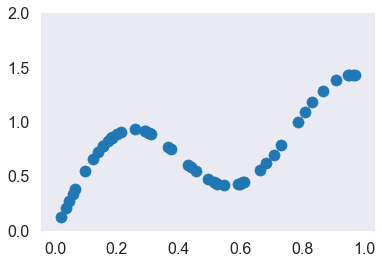

In [277]:
fig, ax = plt.subplots()
ax.scatter(x, y)
s = ax.scatter(x[:, 0], saved_preds[0, :, 0])
ax.set_ylim(0, 2)
def animate(i):
    y_i = saved_preds[i, :, 0]
    s.set_offsets(np.array([x[:, 0], y_i]).T)
    

In [278]:
ani = animation.FuncAnimation(fig, animate, np.arange(50))

In [279]:
HTML(ani.to_html5_video())

## Getting the data

Our forecasts are ECMWF forecasts of temperature taken from the TIGGE dataset which contain forecasts from 2008 to now upscaled to 40km grid spacing. Specifically we look at 48h forecasts initialized at 00UTC. 

The observations are from around 500 DWD surface stations. The forecast data was bilinearly interpolated to the station locations.

We will use all of 2015 for training the model and all of 2016 to test how well the model performs.

In [8]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates)

train set contains 365 days
test set contains 366 days


The raw ensemble contains 50 ensemble members. We take the mean and standard deviations of these 50 values which is a good approximation since temperature is normally distributed.

In [9]:
train_set.feature_names

['t2m_fc_mean', 't2m_fc_std']

In total we have around 500 stations for every day with some missing observation data. In total that makes around 180k samples.

In [44]:
len(np.unique(train_set.station_ids))

500

In [11]:
train_set.features.shape, train_set.targets.shape

((180849, 2), (180849,))

In [48]:
def plot_fc(data_set, idx, distr='pdf'):
    fc = data_set.features[idx] * data_set.scale_factors
    obs = data_set.targets[idx]
    x = np.linspace(fc[0] - 5 * fc[1], fc[0] + 5 * fc[1], 100)
    if distr == 'pdf':
        y = norm.pdf(x, fc[0], fc[1])
    elif distr == 'cdf':
        y = norm.cdf(x, fc[0], fc[1])
    else:
        raise Exception
    plt.plot(x, y)
    plt.axvline(obs, color='red')
    plt.xlabel('Temperature [C]')
    plt.show()

The goal of post-processing is to produce a sharp but reliable distribution.

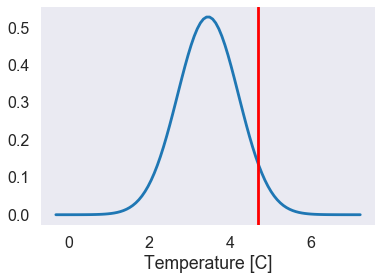

In [49]:
plot_fc(train_set, 1001)

To measure the skill of the forecast, we use the CRPS: 


$$ \mathrm{crps}(F, y) = \int_{-\infty}^{\infty} [F(t) - H(t-y)]^2\mathrm{d}t, $$

where $F(t)$ is the forecast CDF and $H(t-y)$ is the Heaviside function.

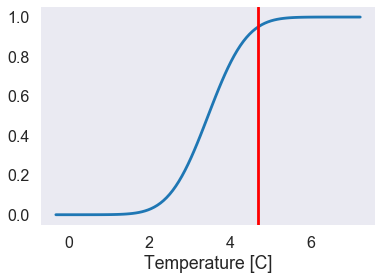

In [50]:
plot_fc(train_set, 1001, 'cdf')

For a normal distribution we can easily compute the CRPS from the mean and standard deviation for the raw ensemble, which is the score we want to improve.

In [47]:
np.mean(crps_normal(
    test_set.features[:, 0] * test_set.scale_factors[0], 
    test_set.features[:, 1] * test_set.scale_factors[1], 
    test_set.targets
))

1.1518655803872713

## Simple postprocessing

The most common post-processing technique for this sort of problem is called Ensemble Model Output Statistic (Gneiting et al. 2005). In this technique, the goal is to find a distribution
$$ \mathcal{N}(a + bX, c + dS^2), $$
where $X$ is the raw ensemble mean and $S$ is the raw ensemble standard deviation, so that 
$$ \min_{a, b, c, d} \frac{1}{N_{\mathrm{sample}}} \sum_{i = 1}^{N_{\mathrm{sample}}} crps(\mathcal{N}(a + bX, c + dS^2), y_i)$$
The minimum over all samples is found using some optimization algorithm. We can also view this as a network graph

![EMOS_Network](EMOS_Network.png)

There are two commonly used variant of EMOS: Global EMOS where all stations share the same coefficients and training happens over a rolling window of e.g. 25 days and local EMOS where each station is fit separately with a longer training window (e.g. 1 year).

The CRPS scores for 2016 are:
- Global EMOS: 1.01
- Local EMOS: 0.92

This is the benchmark for our networks.

Let's start by fitting a very simple fully connected network like this:
![fc_network](fc_network.png)

In [59]:
# Build the network using Keras
fc_model = Sequential([
    Dense(2, input_dim=2)
])

In [60]:
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [61]:
fc_model.compile(Adam(0.1), crps_cost_function)

In [62]:
fc_model.fit(train_set.features, train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.7875     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.7402     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.3722     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 2.0094     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.6630     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.3781     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.1932     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.1077     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0795     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 1.0720     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 1.0701     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 1.0695     
E

In [65]:
# Now display the score for 2016
fc_model.evaluate(test_set.features, test_set.targets, 4096, verbose=0)

1.0128482668843812

So we basically get the same score as global EMOS, which is what we would expect.

### Add station information with embeddings

The stations probably differ a lot in their post-processing characteristics. So we want to include this somehow. In local EMOS, we wit a separate model for each station, but this takes a long time and doesn't optimally use all the training data.

Embeddings are a neural network technique which provide a natural way to include station information. An embedding is a mapping from a discrete object, in our case the station ID, to a vector. The elements of the vector are learned by the network just like the other weights and biases and represent some extra information about each station.

In [127]:
emb_size = 2
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
max_id

536

In [128]:
features_inp = Input(shape=(2,))
id_inp = Input(shape=(1,))
emb = Embedding(max_id+1, emb_size)(id_inp)
emb = Flatten()(emb)
x = Concatenate()([features_inp, emb])
outp = Dense(2)(x)
emb_model = Model([features_inp, id_inp], outp)

In [129]:
emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 2)          1074        input_8[0][0]                    
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 2)             0           embedding_4[0][0]                
___________________________________________________________________________________________

In [130]:
emb_model.compile(Adam(0.1), crps_cost_function)

In [131]:
emb_model.fit([train_set.features, train_set.cont_ids], train_set.targets,
              epochs=20, batch_size=4096);

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.1737     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.7637     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.2830     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.8283     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.4332     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.1565     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0219     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9802     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9714     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9697     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9695     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9694     
E

In [132]:
emb_model.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.91235853035206693

This score is about 1% better than local EMOS and is much faster.

### What about a neural network?

So far the network we used were simple linear networks, nothing neural about them. Let's try adding a hidden layer.

In [134]:
def create_emb_hidden_model(hidden_nodes, n_features=2, activation='relu'):
    features_inp = Input(shape=(n_features,))
    id_inp = Input(shape=(1,))
    emb = Embedding(max_id+1, emb_size)(id_inp)
    emb = Flatten()(emb)
    x = Concatenate()([features_inp, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation)(x)
    outp = Dense(2)(x)
    return Model([features_inp, id_inp], outp)

In [140]:
neural_net = create_emb_hidden_model([10])
neural_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 2)          1074        input_12[0][0]                   
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 2)             0           embedding_6[0][0]                
___________________________________________________________________________________________

In [141]:
neural_net.compile(Adam(0.1), crps_cost_function)

In [142]:
neural_net.fit([train_set.features, train_set.cont_ids], train_set.targets, 
               epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 3.6254     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 1.1819     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 1.0104     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 0.9840     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 0.9788     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 0.9762     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 0.9744     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9733     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9718     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9692     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9681     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9691     
E

In [143]:
neural_net.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.92509797401748739

In [154]:
neural_net = create_emb_hidden_model([1024, 1024])
neural_net.compile(Adam(0.01), crps_cost_function)
neural_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 1, 2)          1074        input_22[0][0]                   
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_11 (Flatten)             (None, 2)             0           embedding_11[0][0]               
___________________________________________________________________________________________

In [155]:
neural_net.fit([train_set.features, train_set.cont_ids], train_set.targets, 
               epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 1s - loss: 1.6733     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 0.9787     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 0.9740     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 0.9719     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 0.9663     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 0.9646     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 0.9606     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9655     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9639     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9670     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9572     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9599     
E

In [152]:
neural_net.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.9220620622779756

## Adding more variables

So far we have only used the temperature forecast as input but really we have a lot more variables from each forecast which might give us more information about the weather situation. 

In traditional post-processing there are techniques to utilize these auxiliary variables, called boosting techniques. 

Here are the benchmark scores from Sebastian's boosting experiments:
- global boosting: 0.97
- local boosting: 0.87

As a first attempt we can simply throw in these extra variables to our standard network and see what happens. 

In [156]:
aux_dict

OrderedDict([('data_aux_geo_interpolated.nc',
              ['orog', 'station_alt', 'station_lat', 'station_lon']),
             ('data_aux_pl500_interpolated_00UTC.nc',
              ['u_pl500_fc', 'v_pl500_fc', 'gh_pl500_fc']),
             ('data_aux_pl850_interpolated_00UTC.nc',
              ['u_pl850_fc', 'v_pl850_fc', 'q_pl850_fc']),
             ('data_aux_surface_interpolated_00UTC.nc',
              ['cape_fc', 'sp_fc', 'tcc_fc']),
             ('data_aux_surface_more_interpolated_part1_00UTC.nc',
              ['sshf_fc', 'slhf_fc', 'u10_fc', 'v10_fc']),
             ('data_aux_surface_more_interpolated_part2_00UTC.nc',
              ['ssr_fc', 'str_fc', 'd2m_fc', 'sm_fc'])])

In [162]:
#aux_train_set, aux_test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_15_16.pkl', 'rb') as f:
    aux_train_set, aux_test_set = pickle.load(f)

In [165]:
print(aux_train_set.feature_names)
len(aux_train_set.feature_names)

['t2m_fc_mean', 't2m_fc_std', 'orog', 'station_alt', 'station_lat', 'station_lon', 'u_pl500_fc_mean', 'u_pl500_fc_std', 'v_pl500_fc_mean', 'v_pl500_fc_std', 'gh_pl500_fc_mean', 'gh_pl500_fc_std', 'u_pl850_fc_mean', 'u_pl850_fc_std', 'v_pl850_fc_mean', 'v_pl850_fc_std', 'q_pl850_fc_mean', 'q_pl850_fc_std', 'cape_fc_mean', 'cape_fc_std', 'sp_fc_mean', 'sp_fc_std', 'tcc_fc_mean', 'tcc_fc_std', 'sshf_fc_mean', 'sshf_fc_std', 'slhf_fc_mean', 'slhf_fc_std', 'u10_fc_mean', 'u10_fc_std', 'v10_fc_mean', 'v10_fc_std', 'ssr_fc_mean', 'ssr_fc_std', 'str_fc_mean', 'str_fc_std', 'd2m_fc_mean', 'd2m_fc_std', 'sm_fc_mean', 'sm_fc_std']


40

As with temperature, we took the ensemble mean and standard deviation of all auxiliary variables (except for the constants). Now we can build the same network as earlier but with 40 inputs.

### Simple linear net with auxiliary variables

In [167]:
aux_fc_model = Sequential([
    Dense(2, input_dim=40)
])
aux_fc_model.compile(Adam(0.1), crps_cost_function)
aux_fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [168]:
aux_fc_model.fit(aux_train_set.features, aux_train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 3.9703     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 1.7954     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 1.4347     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.2368     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.1294     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.0710     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0373     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.0159     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0008     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9902     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9822     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9772     
E

In [170]:
aux_fc_model.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0)

0.92275059023247719

So we get a big improvement from 1.01 for only temperature. we are also doing better than global boosting. Next let's include our station embeddings.

### Auxiliary variables with station embeddings

In [189]:
aux_emb_model = create_emb_hidden_model([], n_features=40)
aux_emb_model.compile(Adam(0.01), crps_cost_function)
aux_emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_34 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_17 (Embedding)         (None, 1, 2)          1074        input_34[0][0]                   
____________________________________________________________________________________________________
input_33 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_17 (Flatten)             (None, 2)             0           embedding_17[0][0]               
___________________________________________________________________________________________

In [190]:
aux_emb_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 2.7484     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 1.9120     
Epoch 3/50
180849/180849 [==============================] - 1s - loss: 1.6414     
Epoch 4/50
180849/180849 [==============================] - 1s - loss: 1.4628     
Epoch 5/50
180849/180849 [==============================] - 1s - loss: 1.3345     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 1.2397     
Epoch 7/50
180849/180849 [==============================] - 1s - loss: 1.1709     
Epoch 8/50
180849/180849 [==============================] - 1s - loss: 1.1164     
Epoch 9/50
180849/180849 [==============================] - 1s - loss: 1.0768     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 1.0460     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 1.0223     
Epoch 12/50
180849/180849 [==============================] - 1s - loss: 1.0044     
E

In [191]:
aux_emb_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.88047864579355228

This is slightly worse than the local boosting algorithm.

### Neural network

So far we have only used linear networks. Now let's add some non-linearity with one hidden layer.

In [195]:
nn_model = create_emb_hidden_model([50], n_features=40)
nn_model.compile(Adam(0.01), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_38 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_19 (Embedding)         (None, 1, 2)          1074        input_38[0][0]                   
____________________________________________________________________________________________________
input_37 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_19 (Flatten)             (None, 2)             0           embedding_19[0][0]               
___________________________________________________________________________________________

In [196]:
nn_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
             epochs=30, batch_size=1024);

Epoch 1/30
180849/180849 [==============================] - 1s - loss: 1.6817     
Epoch 2/30
180849/180849 [==============================] - 1s - loss: 0.9634     
Epoch 3/30
180849/180849 [==============================] - 1s - loss: 0.9216     
Epoch 4/30
180849/180849 [==============================] - 1s - loss: 0.8934     
Epoch 5/30
180849/180849 [==============================] - 1s - loss: 0.8750     
Epoch 6/30
180849/180849 [==============================] - 1s - loss: 0.8678     
Epoch 7/30
180849/180849 [==============================] - 1s - loss: 0.8573     
Epoch 8/30
180849/180849 [==============================] - 1s - loss: 0.8537     - ET
Epoch 9/30
180849/180849 [==============================] - 1s - loss: 0.8500     
Epoch 10/30
180849/180849 [==============================] - 1s - loss: 0.8528     
Epoch 11/30
180849/180849 [==============================] - 1s - loss: 0.8477     
Epoch 12/30
180849/180849 [==============================] - 1s - loss: 0.8471   

In [197]:
nn_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.84089550482280651

The added non-linearity gives us a another few percent improvement compared to the local boosting algorithm. Why not try increasing the number of hidden layers and nodes?

### A more complex neural network

In [198]:
better_nn = create_emb_hidden_model([512, 512], 40)
better_nn.compile(Adam(0.01), crps_cost_function)
better_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_40 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_20 (Embedding)         (None, 1, 2)          1074        input_40[0][0]                   
____________________________________________________________________________________________________
input_39 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_20 (Flatten)             (None, 2)             0           embedding_20[0][0]               
___________________________________________________________________________________________

In [199]:
better_nn.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
             epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 1.7381     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 0.9359     
Epoch 3/50
180849/180849 [==============================] - 1s - loss: 0.8731     
Epoch 4/50
180849/180849 [==============================] - 1s - loss: 0.8575     
Epoch 5/50
180849/180849 [==============================] - 1s - loss: 0.8410     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 0.8214     
Epoch 7/50
180849/180849 [==============================] - 1s - loss: 0.8282     
Epoch 8/50
180849/180849 [==============================] - 1s - loss: 0.8021     
Epoch 9/50
180849/180849 [==============================] - 1s - loss: 0.7969     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 0.7876     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 0.7910     
Epoch 12/50
180849/180849 [==============================] - 1s - loss: 0.7872     
E

In [200]:
better_nn.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.92146556577521399

### Hmmm, weird...

This is what is called overfitting and is a serious problem in machine learning. The model basically memorizes the training examples and does not generalize to unseen samples.

![overfitting](https://i.stack.imgur.com/t0zit.png)

The model complexity is limited by the amount of training data!

## A longer training period

Finally, let's see if our score gets better if we train with a longer training period. 

In [201]:
long_train_dates = ['2008-01-01', '2016-01-01']
#long_train_set, long_test_set = get_train_test_sets(DATA_DIR, long_train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_08-15_16.pkl', 'rb') as f:
    long_train_set, long_test_set = pickle.load(f)

In [202]:
long_train_set.features.shape

(1456977, 40)

In [204]:
nn_model = create_emb_hidden_model([500], n_features=40)
nn_model.compile(Adam(0.002), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_44 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_22 (Embedding)         (None, 1, 2)          1074        input_44[0][0]                   
____________________________________________________________________________________________________
input_43 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_22 (Flatten)             (None, 2)             0           embedding_22[0][0]               
___________________________________________________________________________________________

In [206]:
nn_model.fit([long_train_set.features, long_train_set.cont_ids], long_train_set.targets, 
             epochs=100, batch_size=4096, validation_split=0.2,
             callbacks=[EarlyStopping(patience=2)]);

Train on 1165581 samples, validate on 291396 samples
Epoch 1/100
1165581/1165581 [==============================] - 3s - loss: 1.6775 - val_loss: 0.9277
Epoch 2/100
1165581/1165581 [==============================] - 3s - loss: 0.9151 - val_loss: 0.8581
Epoch 3/100
1165581/1165581 [==============================] - 3s - loss: 0.8711 - val_loss: 0.8342
Epoch 4/100
1165581/1165581 [==============================] - 3s - loss: 0.8554 - val_loss: 0.8273
Epoch 5/100
1165581/1165581 [==============================] - 3s - loss: 0.8495 - val_loss: 0.8234
Epoch 6/100
1165581/1165581 [==============================] - 3s - loss: 0.8417 - val_loss: 0.8187
Epoch 7/100
1165581/1165581 [==============================] - 3s - loss: 0.8367 - val_loss: 0.8193
Epoch 8/100
1165581/1165581 [==============================] - 3s - loss: 0.8328 - val_loss: 0.8156
Epoch 9/100
1165581/1165581 [==============================] - 3s - loss: 0.8281 - val_loss: 0.8133
Epoch 10/100
1165581/1165581 [=================

In [208]:
nn_model.evaluate([long_test_set.features, long_test_set.cont_ids], 
                       long_test_set.targets, 4096, 0)

0.78611633710993412

So we got another 4% improvement with more training data. We do not yet have benchmark scores for the traditional post-processing techniques for the long training period.

## Conclusion

Neural network provide a flexible and fast way of post-processing probabilistic NWP forecasts and are even a little better than traditional techniques courtesy of the added non-linearity. 

This is however an academic dataset with a nicely behaved variable, temperature. Application-driven post-processing poses some extra challenges:
- Non-gaussian variables like temperature and wind
- Spatial structures